# Air Quality Index (AQI) Data Retrieval, Cleaning, and Exploration

## Introduction

This notebook demonstrates how to access, clean, and explore historical air quality data for the United States, retrieved through the US Environmental Protection Agency (EPA) Air Quality System (AQS) API. The EPA's AQS API provides historical data on air quality parameters, allowing users to retrieve and analyze daily air quality measurements. This project does not focus on real-time data but instead examines past air quality patterns across different regions to uncover trends and gain insights into the levels of particulate matter and gaseous pollutants.

### Objective
The primary objective of this notebook is to:
1. **Retrieve Data**: Use the EPA's AQS API to request historical AQI data, specifically focusing on parameters related to particulate matter and gaseous pollutants.
2. **Data Cleaning**: Structure and clean the retrieved data to ensure it’s ready for analysis. This includes handling missing values, organizing data fields, and removing any unnecessary information.
3. **Data Exploration**: Perform exploratory data analysis to gain insights into air quality trends over time, specifically focusing on seasonal and annual variations.

### Background
The code used in this notebook is adapted from a previous example that demonstrated various types of requests made through the EPA’s AQS API. That original notebook showed how to work with the AQS API to retrieve essential identifiers, query data on air quality parameters, and obtain summary data. Here, we build on that foundation by focusing on retrieving specific data relevant to our research area, processing that data for usability, and then conducting exploratory analysis.

### About the EPA and AQS API
The EPA was established in the early 1970s, and standardized air quality monitoring began in the 1980s, although some areas lacked monitoring coverage. The AQS API provides a way to query this historical data, either by monitoring station, county, or geographic area, allowing for flexible data access and tailored research queries. For this notebook, the data will be retrieved using county-based and bounding box queries.

The Air Quality Index (AQI) is a standardized measure that translates complex air quality data into a format easily understood by the public, indicating air health on a daily basis. This notebook’s retrieval and exploration of AQI-related data will allow us to observe trends in air pollutants, particularly focusing on smoke and smog impacts.

### Notebook Outline
1. **API Data Retrieval**: Access AQI data for specified pollutants and time periods using the EPA AQS API.
2. **Data Cleaning**: Ensure the data is consistent and structured, handling any irregularities or missing values.
3. **Data Exploration**: Perform initial analysis to uncover patterns, seasonal trends, and other insights within the AQI data for selected regions.
   
### Acknowledgements
This notebook is adapted from example code developed by Dr. David W. McDonald for DATA 512, a course in the UW MS Data Science program. 

## Imports

In [1]:
import json
import time
import requests
import numpy as np
import pandas as pd

## Constants

In [2]:
#    This is the root of all AQS API URLs
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

AQI_PARAM_CLASS = "AQI POLLUTANTS"
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201" #Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_PARTICULATES = "81102,88101,88502" # Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5

EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

TALLAHASSEE_INFO = {   
    "state_FIPS":  "12",  
    "county_FIPS": "073",
    "lat":    30.46,
    "lon":    -84.25,
    "minlat": 29.71366231884058,
    "maxlat": 31.162937681159423,
    "minlon": -85.19645091575092,
    "maxlon": -83.36494908424908,
}

USERNAME = 'kateroll@gmail.com'
APIKEY = 'silverfox66'

## Define Functions

In [3]:
def request_list_info(email_address = None,
                      key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def request_daily_summary(email_address = None,
                          key = None,
                          param=None,
                          begin_date = None,
                          end_date = None,
                          fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def extract_summary_from_response(r=None, 
                                  fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result

#
#    This implements the monitors request. This requests monitoring stations. This can be done by state, county, or bounding box. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_monitors(email_address = None,
                     key = None,
                     param=None,
                     begin_date = None,
                     end_date = None,
                     fips = None,
                     endpoint_url = API_REQUEST_URL, 
                     endpoint_action = API_ACTION_MONITORS_COUNTY, 
                     request_template = AQS_REQUEST_TEMPLATE,
                     headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Retrieve AQI Data 

Lets do a test to make sure we're getting the right info before looping through all the dates

In [4]:
# Set the query parameters
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = TALLAHASSEE_INFO["state_FIPS"]
request_data['county'] = TALLAHASSEE_INFO["county_FIPS"]
request_data['param'] = AQI_PARAMS_PARTICULATES

# request daily summary data for the month of July in 2021
particulate_aqi = request_daily_summary(request_template=request_data, 
                                        begin_date="20210701",
                                        end_date="20210731")

extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))

Summary of particulate extraction ...
{
    "0012": {
        "local_site_name": "Tallahassee Community College",
        "site_address": "110 CENTURY PARK CIRCLE WEST",
        "state": "Florida",
        "county": "Leon",
        "city": "Tallahassee",
        "pollutant_type": {
            "88101": {
                "parameter_name": "PM2.5 - Local Conditions",
                "units_of_measure": "Micrograms/cubic meter (LC)",
                "method": "R & P Model 2025 PM-2.5 Sequential Air Sampler w/VSCC - Gravimetric",
                "data": {
                    "20210709": [
                        {
                            "sample_duration": "24 HOUR",
                            "observation_count": 1,
                            "arithmetic_mean": 4.4,
                            "aqi": 24
                        },
                        {
                            "sample_duration": "24 HOUR",
                            "observation_count": 1,
                   

Okay now that we've seen that we can get readings, lets get readings for our time periods.

We are interested in 1961-2021 but just during the fire season which runs May 1 - October 31st

In [5]:
# Define the start and end years for data retrieval
start_year = 1975
end_year = 1998

# Initialize list to store the data
all_aqi_data = []

# Loop through each year
for year in range(start_year, end_year + 1):
    # Set the date range for the entire year
    year_start = f"{year}0101"
    year_end = f"{year}1231"
    
    # Request data for particulates
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    request_data['param'] = AQI_PARAMS_PARTICULATES
    request_data['state'] = TALLAHASSEE_INFO["state_FIPS"]
    request_data['county'] = TALLAHASSEE_INFO["county_FIPS"]
    
    response_particulates = request_daily_summary(
        request_template=request_data,
        begin_date=year_start,
        end_date=year_end
    )
    
    # Request data for gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    response_gaseous = request_daily_summary(
        request_template=request_data,
        begin_date=year_start,
        end_date=year_end
    )

    # Store data if requests are successful
    if response_particulates and response_gaseous:
        all_aqi_data.append({
            'year': year,
            'particulates': response_particulates,
            'gaseous': response_gaseous
        })

    # Print status for each year's data retrieval
    print(f"Data retrieved for {year}")

# Display the data for verification
print(json.dumps(all_aqi_data, indent=4))

Data retrieved for 1975
Data retrieved for 1976
Data retrieved for 1977
Data retrieved for 1978
Data retrieved for 1979
Data retrieved for 1980
Data retrieved for 1981
Data retrieved for 1982
Data retrieved for 1983
Data retrieved for 1984
Data retrieved for 1985
Data retrieved for 1986
Data retrieved for 1987
Data retrieved for 1988
Data retrieved for 1989
Data retrieved for 1990
Data retrieved for 1991
Data retrieved for 1992
Data retrieved for 1993
Data retrieved for 1994
Data retrieved for 1995
Data retrieved for 1996
Data retrieved for 1997
Data retrieved for 1998


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now lets save it as a dataframe to explore and clean up the data

In [6]:
aqi_df = pd.json_normalize(all_aqi_data)

In [7]:
aqi_df

,year,particulates.Header,particulates.Data,gaseous.Header,gaseous.Data
0,1975,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
1,1976,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
2,1977,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'No data matched your selection', ...",[]
3,1978,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
4,1979,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
5,1980,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
6,1981,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
7,1982,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
8,1983,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."
9,1984,"[{'status': 'No data matched your selection', ...",[],"[{'status': 'Success', 'request_time': '2024-1...","[{'state_code': '12', 'county_code': '073', 's..."


## Data Cleanup & Exploration

In [8]:
# Define a list to hold the cleaned data
cleaned_data = []

# Loop through each row in the DataFrame
for _, row in aqi_df.iterrows():
    year = row['year']
    
    # Extract data from particulates
    if row['particulates.Header'][0].get('status') == 'Success' and row['particulates.Data']:
        for particulate_data in row['particulates.Data']:
            cleaned_data.append({
                'year': year,
                'type': 'particulate',
                **particulate_data  # Unpack particulate data fields
            })
    
    # Extract data from gaseous
    if row['gaseous.Header'][0].get('status') == 'Success' and row['gaseous.Data']:
        for gaseous_data in row['gaseous.Data']:
            cleaned_data.append({
                'year': year,
                'type': 'gaseous',
                **gaseous_data  # Unpack gaseous data fields
            })

# Convert cleaned data to DataFrame
cleaned_aqi_df = pd.DataFrame(cleaned_data)

In [9]:
cleaned_aqi_df.columns

Index(['year', 'type', 'state_code', 'county_code', 'site_number',
       'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter',
       'sample_duration_code', 'sample_duration', 'pollutant_standard',
       'date_local', 'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [10]:
cleaned_aqi_df.head()

,year,type,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
1,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
2,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
3,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
4,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04


Lets get just the entries where we have an aqi reading

In [11]:
cleaned_aqi_df

,year,type,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
1,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
2,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
3,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
4,1975,gaseous,12,073,0008,42101,1,30.489394,-84.285195,WGS84,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,WONS RADIO STATION,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2018-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21246,1998,gaseous,12,073,0012,44201,1,30.439722,-84.346389,WGS84,...,047,INSTRUMENTAL - ULTRA VIOLET,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2023-02-05
21247,1998,gaseous,12,073,0012,44201,1,30.439722,-84.346389,WGS84,...,047,INSTRUMENTAL - ULTRA VIOLET,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2023-02-05
21248,1998,gaseous,12,073,0012,44201,1,30.439722,-84.346389,WGS84,...,None,-,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2024-09-05
21249,1998,gaseous,12,073,0012,44201,1,30.439722,-84.346389,WGS84,...,None,-,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,45220,"Tallahassee, FL",2024-09-05


In [12]:
aqis_present = cleaned_aqi_df.loc[cleaned_aqi_df['aqi'].notna()].copy()

In [13]:
aqis_present['year'].unique()

array([1975, 1976, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1991, 1992, 1995, 1996, 1997, 1998], dtype=int64)

lets subset it even more to just some columns of interest

In [14]:
daily_multi_aqi_df = aqis_present[["year", "date_local", "site_number", "latitude", "longitude", "aqi"]].copy()
daily_multi_aqi_df.drop_duplicates(inplace = True)
daily_multi_aqi_df.to_csv('AQI_daily_multi_1975-1998.csv', index = False)

In [15]:
# Remove latitude and longitude columns and compute average AQI per date
daily_multi_aqi_df["date_local"] = pd.to_datetime(daily_multi_aqi_df["date_local"])  # Ensure dates are in datetime format
avg_daily_aqi_df = daily_multi_aqi_df.groupby("date_local", as_index=False).agg({"aqi": "mean"})
avg_daily_aqi_df.to_csv('AQI_daily_avg_1975-1998.csv', index = False)

## Lets Save the data

In [71]:
cleaned_aqi_df.to_csv('all_pollutant_data.csv', index = False)
aqis_present.to_csv('all_aqi_data.csv', index = False)
aqi_subset.to_csv('subset_aqi_data.csv', index = False)

## Brief data visualization

lets do some quick plotting to see what these aqi readings look like

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

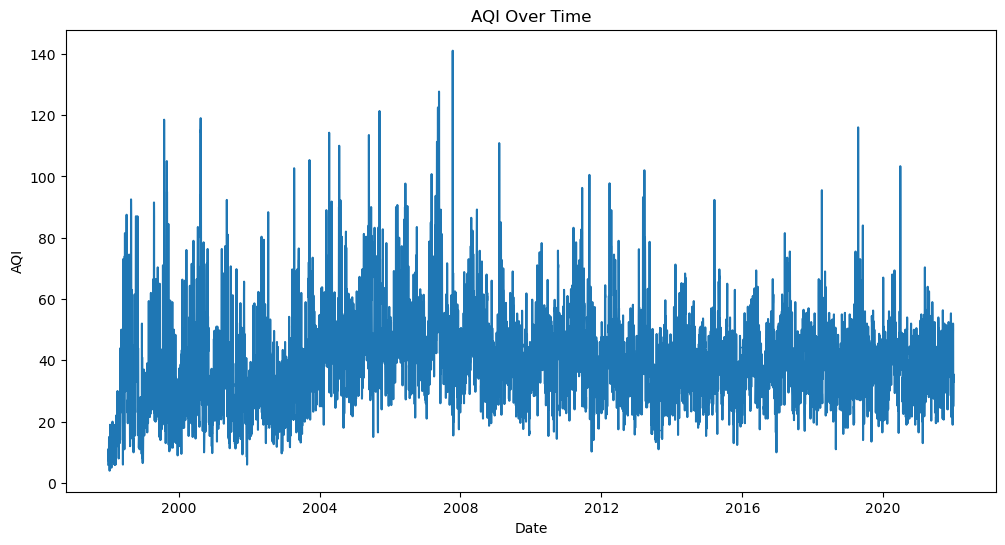

In [24]:
# Convert "date_local" to datetime if it’s not already
avg_daily_aqi_df['date_local'] = pd.to_datetime(avg_daily_aqi_df['date_local'])

# Plotting the standard time series of AQI over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_daily_aqi_df, x='date_local', y='aqi')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Over Time')
plt.show()

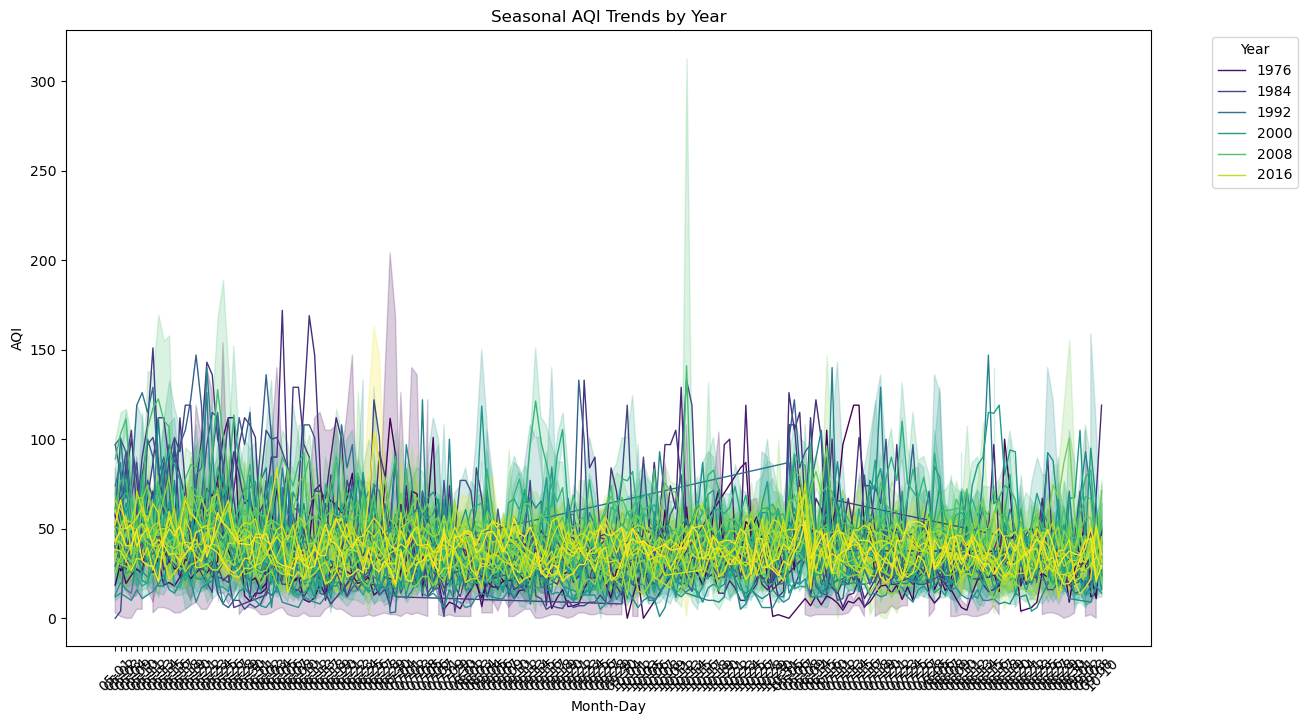

In [72]:
# Extract year, month, and day to create a seasonal plot
aqi_subset['year'] = aqi_subset['date_local'].dt.year
aqi_subset['month_day'] = aqi_subset['date_local'].dt.strftime('%m-%d')  # Format as MM-DD for a consistent x-axis

# Plot seasonal time series with each year as a separate line
plt.figure(figsize=(14, 8))
sns.lineplot(data=aqi_subset, x='month_day', y='aqi', hue='year', palette='viridis', linewidth=1)
plt.xlabel('Month-Day')
plt.ylabel('AQI')
plt.title('Seasonal AQI Trends by Year')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()